In [22]:
from pytransform3d.rotations import plot_basis
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.rotations as pr
import pytransform3d.transformations as pt
from pytransform3d.transform_manager import TransformManager
import numpy.matlib

In [23]:
from scipy.linalg import expm, sinm, cosm
from numpy import linalg as LA

#initialization
N = 5
R_ = np.zeros((N,3,3))
R_[0,:,:] = np.identity(3)
for i in range(R_.shape[0]-1):
    w = np.random.randn(3,1);
    w = w/LA.norm(w)*np.pi*np.random.randn(1)
    R_[i+1,:,:]=expm(np.array([[0, -w[2][0], w[1][0]], [w[2][0], 0, -w[0][0]], [-w[1][0], w[0][0], 0]])
)


In [24]:
def w2R(w):
    
    '''
    rotation vector to rotation matrix
    '''
    
    omega=LA.norm(w);
    R=np.zeros((3,3))

    if(omega):
        
        n = w/omega;

        s = np.sin(omega);
        c = np.cos(omega);
        cc = 1 - c;

        n1=n[0];                n2=n[1];                n3=n[2];
        n12cc=n1*n2*cc;         n23cc=n2*n3*cc;         n31cc=n3*n1*cc;
        n1s=n1*s;               n2s=n2*s;               n3s=n3*s;

        R[0,0]=c+n1*n1*cc;      R[0,1]=n12cc-n3s;       R[0,2]=n31cc+n2s;
        R[1,0]=n12cc+n3s;       R[1,1]=c+n2*n2*cc;      R[1,2]=n23cc-n1s;
        R[2,0]=n31cc-n2s;       R[2,1]=n23cc+n1s;       R[2,2]=c+n3*n3*cc;
    else:
        R=np.identity(3);
    
    return R

In [ ]:
def R2w(R):
    
    '''
    rotation matrix to rotation vector
    '''
    
    w = np.array([[R[2,1]-R[1,2],R[0,2]-R[2,0],R[1,0]-R[0,1]]])
    w = w/2
    
    s = LA.norm(w)
    if(s):
        w=w/s*math.atan2(s, (R.trace()-1)/2);  
        
    return w

In [25]:
def RandomSO3Graph(N,Completeness,Sigma, Noutlier):
    
    '''
    Input:
        N : Number of nodes or View Points 
        Completeness : complete graph if Completeness = 1
        Sigma : Noise added to Relative Rotations in radian
        Noutlier : Number of Outliers
    Output:
        R_ : Absolute Rotations
        RR : Relative Rotation Matrices
        I  : Indices
    '''
    Completeness = 1
    Sigma=Sigma*np.pi/180/np.sqrt(3);
    #Outlier=round(N*(N-1)*Completeness*Outlier);

    R_ = np.zeros((N,3,3))
    R_[0,:,:] = np.identity(3)
    
    #initialization
    for i in range(R_.shape[0]-1):
        w = np.random.randn(3,1);
        w = w/LA.norm(w)*np.pi*np.random.randn(1)
        R_[i+1,:,:]=expm(np.array([[0, -w[2][0], w[1][0]], [w[2][0], 0, -w[0][0]], 
                                   [-w[1][0], w[0][0], 0]]))
        
    num_pairs = int(N*(N-1)*0.5)
    I=np.zeros((2,num_pairs))
    RR=np.zeros((num_pairs,3,3))
    
    k = 0;

    for i in range(N-1):
        for j in range(i+1,N):       
            I[:,k]=np.array([i,j])#[i;j];    
            RR[k,:,:]=R_[j,:,:]*R_[i,:,:].T;
            k=k+1;
    
    #add some noise
    for i in range(RR.shape[0]):
        RR[i,:,:] = RR[i,:,:]*w2R(Sigma*np.random.randn(3,1));
        
    #add some outliers
    bad = np.random.permutation(RR.shape[0])
    bad = bad[0:Noutlier]
    for j in range(bad.shape[0]):
        RR[bad[j],:,:] = w2R(100*np.pi*np.random.randn(3,1));
    
    return R_,RR,I

In [26]:
def RotationMatrix_to_Quaternion(RR):
    
    QQ = np.array([RR[:,0,0]+RR[:,1,1]+RR[:,2,2]-1, RR[:,2,1]-RR[:,1,2],RR[:,0,2]-RR[:,2,0],RR[:,1,0]-RR[:,0,1]])
    QQ = QQ/2    
    QQ = np.reshape(QQ,(QQ.shape[1],4))
    
    QQ[:,0]=np.sqrt((QQ[:,0]+1)/2);
    #print(QQ[:,1:4].shape)
    QQ[:,1:4] = np.divide(QQ[:,1:4],np.matlib.repmat(QQ[:,0].reshape(-1,1),1,3))
    
    return QQ

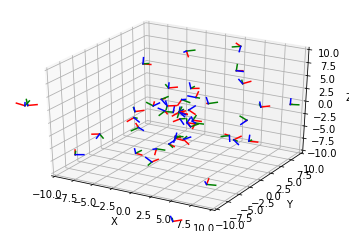

In [27]:
R_,RR,I = RandomSO3Graph(50,1,1,2)
ax = plot_basis(R=R_[1,:,:], ax_s=10)
axis = 0
angle = np.pi / 2

for i in range(R_.shape[0]-1):
    t = np.random.randn(3,)*np.random.randint(15)
    R_new = R_[i+1,:,:]
    plot_basis(ax, R_new, t)
plt.show()